In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
import matplotlib.pyplot as plt

In [37]:
# Read in the panos_5.csv file
df = pd.read_csv('panos.csv')

# Display the first few rows to verify the data was loaded correctly
df.head()


,pano_id,lat,lon
0,bUGfUXM-ojSorfEF7bwIBQ,34.036371,-118.454006
1,hRw1KV1SLiM3EXYZCCwNlg,34.036445,-118.454069
2,42xb66Sof9Y3pPVs1Cuncw,34.036298,-118.453943
3,p1beIhVTANaYc69iUhsBTg,34.035921,-118.453612
4,oSlFbp50Wb7VW2fCB9ed6A,34.035995,-118.453676


Number of clusters: 404677
                  pano_id        lat         lon  cluster
0  bUGfUXM-ojSorfEF7bwIBQ  34.036371 -118.454006        0
1  hRw1KV1SLiM3EXYZCCwNlg  34.036445 -118.454069        1
2  42xb66Sof9Y3pPVs1Cuncw  34.036298 -118.453943        2
3  p1beIhVTANaYc69iUhsBTg  34.035921 -118.453612        3
4  oSlFbp50Wb7VW2fCB9ed6A  34.035995 -118.453676        4
5  nMJW2bOyK6SM0-kFg4dF6A  34.036151 -118.453817        5
6  tazxGU1A_1pJ5MdIZnIGiQ  34.036225 -118.453880        6
7  5QBa-udNFpMwJFjFzsCubg  34.036068 -118.453739        7
8  u80YEvRMspJY5t1smbKw8g  34.035149 -118.453056        8
9  5YpEb6uoJyDBM3PKc7i9xw  34.035100 -118.453147        9


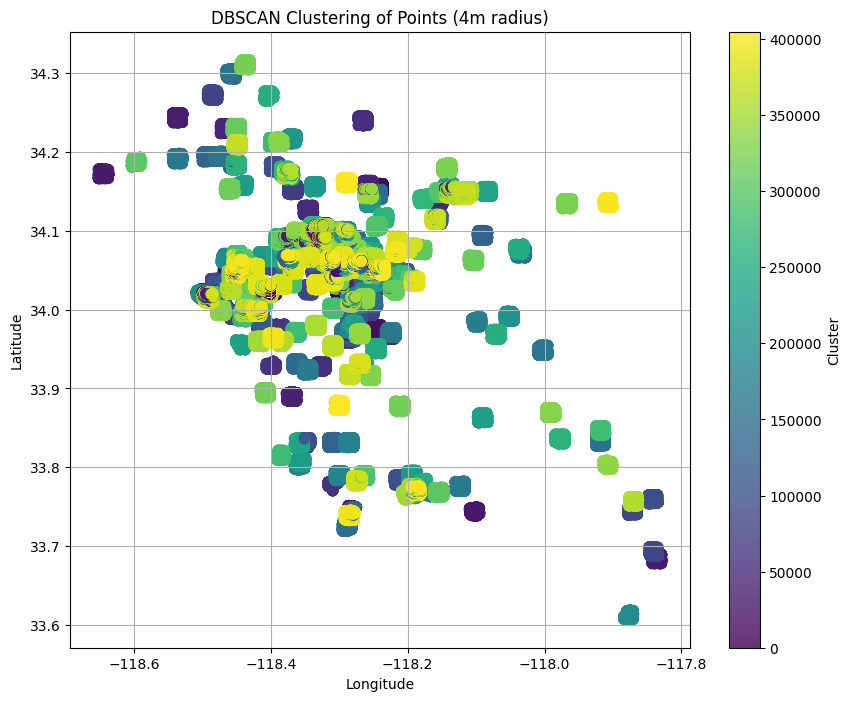

In [38]:
# Import necessary libraries for DBSCAN clustering

# Convert lat/lon to radians for haversine distance calculation
lat_lon_rad = np.radians(df[['lat', 'lon']].values)

# Calculate the epsilon value for DBSCAN
# 4 meters in radians (using LA-specific Earth radius)
# Earth radius varies by latitude - LA is around 34° N
lat_radians = np.radians(34.0)  # Approximate latitude of Los Angeles
earth_radius_km = 6378.137 * (1 - 0.0033528 * np.sin(lat_radians)**2)  # WGS84 ellipsoid model
epsilon_km = 0.004  # 4 meters in kilometers
epsilon_rad = epsilon_km / earth_radius_km

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=epsilon_rad, min_samples=1, metric='haversine')
df['cluster'] = dbscan.fit_predict(lat_lon_rad)

# Display the number of clusters found
num_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
print(f"Number of clusters: {num_clusters}")

# Display the dataframe with cluster assignments
print(df[['pano_id', 'lat', 'lon', 'cluster']].head(10))

# Visualize the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['lon'], df['lat'], c=df['cluster'], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title('DBSCAN Clustering of Points (4m radius)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [47]:
# Save the dataframe with cluster assignments to a CSV file
df.to_csv('panos_with_clusters.csv', index=False)
print("Dataframe saved to 'panos_with_clusters.csv'")


Dataframe saved to 'panos_with_clusters.csv'


In [39]:
df['cluster']

0              0
1              1
2              2
3              3
4              4
           ...  
542103    404673
542104    404674
542105    404675
542106    404676
542107    404605
Name: cluster, Length: 542108, dtype: int64

In [40]:
# Calculate the size of each cluster
cluster_sizes = df.groupby('cluster').size()

# Filter clusters with more than 3 points
large_clusters = cluster_sizes[cluster_sizes > 2]

# Calculate the average size of large clusters
if len(large_clusters) > 0:
    avg_large_cluster_size = large_clusters.mean()
    print(f"Average size of clusters with more than 3 points: {avg_large_cluster_size:.2f} points")
    print(f"Number of clusters with more than 3 points: {len(large_clusters)}")
else:
    print("No clusters with more than 3 points found.")


Average size of clusters with more than 3 points: 10.19 points
Number of clusters with more than 3 points: 14319


In [41]:
# Remove points with less than 3 in their cluster
cluster_sizes = df.groupby('cluster').size()
large_clusters = cluster_sizes[cluster_sizes > 2]
df_filtered = df[df['cluster'].isin(large_clusters.index)]

# For each cluster, select the first point's lat,lon as the cluster location
cluster_locations = df_filtered.groupby('cluster').first()[['lat', 'lon']]

# Create a dictionary mapping cluster location to list of pano_ids
cluster_to_panos = {}
for cluster_id, cluster_df in df_filtered.groupby('cluster'):
    # Get the cluster location (lat, lon)
    cluster_lat = cluster_locations.loc[cluster_id, 'lat']
    cluster_lon = cluster_locations.loc[cluster_id, 'lon']
    cluster_location = (cluster_lat, cluster_lon)
    
    # Get all pano_ids in this cluster
    pano_ids = cluster_df['pano_id'].tolist()
    
    # Add to dictionary
    cluster_to_panos[cluster_location] = pano_ids

# Create a dictionary mapping pano_id to cluster location
pano_to_cluster = {}
for cluster_location, pano_ids in cluster_to_panos.items():
    for pano_id in pano_ids:
        pano_to_cluster[pano_id] = cluster_location

# Print some statistics
print(f"Number of clusters with more than 2 points: {len(cluster_to_panos)}")
print(f"Number of panoramas in these clusters: {len(pano_to_cluster)}")
print("\nSample of cluster_to_panos dictionary:")
sample_items = list(cluster_to_panos.items())[:3]
for location, panos in sample_items:
    print(f"Cluster at {location}: {len(panos)} panoramas")
    if len(panos) > 5:
        print(f"  First 5 pano_ids: {panos[:5]}")
    else:
        print(f"  Pano_ids: {panos}")


Number of clusters with more than 2 points: 14319
Number of panoramas in these clusters: 145863

Sample of cluster_to_panos dictionary:
Cluster at (34.03550752147977, -118.4518280123928): 14 panoramas
  First 5 pano_ids: ['fGwld1B5QdkLR2djdaL3iw', 'Tm4uhnjVRWVkfYBRKq6c6Q', 'Mi4Nbm6jdh5dGIm2Sv2ggA', 'v1QJNO-mxbDNTH2Wv10nsw', '0wMLdHl7apMItNiUAzb5jw']
Cluster at (34.03563383316668, -118.4519490356225): 14 panoramas
  First 5 pano_ids: ['LFFJloVkwXYzP2Q4P5-pxg', 'yP5cSQCvxWcKTcC3qE7Igw', 'QZ0KrVOGeRYsaT9Y9ytrHQ', 'LGgDt4NTFlrqJSIR9JEOnA', 'feN5tUzH7JQ6DxaXGD0Ndw']
Cluster at (34.03570130501672, -118.4491562105476): 18 panoramas
  First 5 pano_ids: ['pvfcgWlgDEWwQ96_XTHRfQ', 'pZOtMNrLyXVc33DDDgJn8A', '-oEHxIS5fz6UFDxY5qbU_g', 'm9gXoNR0Xg9OUk-brSeU9Q', 'qMpbHC4gkVJi2suPDPqWEA']


In [46]:
# Save the cluster_to_panos dictionary to a Python file
with open('clusterpanoref.py', 'w') as f:
    f.write('cluster_to_pano_dict = {\n')
    for cluster_location, pano_ids in cluster_to_panos.items():
        # Format the cluster location as a tuple string
        location_str = f"({cluster_location[0]}, {cluster_location[1]})"
        # Format the pano_ids as a list string
        pano_ids_str = repr(pano_ids)
        f.write(f"    {location_str}: {pano_ids_str},\n")
    f.write('}\n')

# Save the pano_to_cluster dictionary to a Python file
with open('panoclusterref.py', 'w') as f:
    f.write('pano_to_cluster_dict = {\n')
    for pano_id, cluster_location in pano_to_cluster.items():
        # Format the cluster location as a tuple string
        location_str = f"({cluster_location[0]}, {cluster_location[1]})"
        f.write(f"    '{pano_id}': {location_str},\n")
    f.write('}\n')

print(f"Saved cluster_to_panos to clusterpanoref.py")
print(f"Saved pano_to_cluster to panoclusterref.py")
print(type(next(iter(cluster_to_panos.keys()))))  # Verify the type of cluster location


Saved cluster_to_panos to clusterpanoref.py
Saved pano_to_cluster to panoclusterref.py
<class 'tuple'>
